In [1]:
"""
1. do validation of annotation by matching scoring vs silhouette file

2. check which cells are high/low withi neach disc? lump 1x and 2x?


"""

'\n1. do validation of annotation by matching scoring vs silhouette file\n\n2. check which cells are high/low withi neach disc? lump 1x and 2x?\n\n\n'

In [90]:
import sys, os
from time import time
if '../' not in sys.path:
    sys.path.insert(0, '../')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from modules.paths import Experiment
from matplotlib.colors import ListedColormap
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [91]:
def get_stack_df(stack):
    dfs = []
    for layer in stack:
        if layer.include:
            dfs.append(layer.df)
    df = pd.concat(dfs)
    df = df[df.im_label!=-1]
    df = df[df.near_furrow]
    return df

def show_layer(layer, classifier):
    labels = classifier(layer.df)
    xy = layer.df[['centroid_x', 'centroid_y']].values
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
    _ = layer.get_channel('r').show(segments=False, ax=ax0, cmap=plt.cm.Greys)
    ax1.scatter(*xy.T, c=labels, cmap=classifier.cmap, lw=0)
    ax1.invert_yaxis()
    _ = ax1.axis('off')

In [92]:
from matplotlib.colors import ListedColormap
from modules.annotation import Annotation
from modules.io import IO

class AnnotationScoring:
    
    def __init__(self, path):
        self.path = path
        self.name = path.rsplit('/', maxsplit=1)[1].split('_')[0]
        feud = self.get_feud(path)
        self.annotations = {l['id']: l['contours'] for l in feud['layers']}
        self.annotated_layers = list(self.annotations.keys())
        self.nlabels = {k:len(v) for k, v in self.annotations.items()}
        
        # set layer paths
        layer_paths = glob(os.path.join(path, '*[0-9].json'))
        self.layer_paths = {int(p.rsplit('/', maxsplit=1)[1].strip('.json')): p for p in layer_paths}
        self.stack = self.get_stack()
        
        self.figs = {}
        
    @staticmethod
    def get_feud(path):
        io = IO()
        feud = io.read_json(os.path.join(path, 'feud.json'))
        return feud

    def get_layer(self, layer_id, annotated=False):        
        io = IO()
        contours = io.read_json(self.layer_paths[layer_id])['contours']
        df = self.parse_contours(contours)
        annotations = self.get_annotations(layer_id)
        df = pd.merge(df, annotations, on='id', how='outer')
        df.loc[df[df.label=='r8'].index, 'label'] = np.nan
        if annotated:
            df = df[~df.label.isna()]
            df['manual_genotype'] = df.label.apply(lambda x: x[0])
        return df
    
    def get_stack(self):
        dfs = []
        for layer_id in self.annotated_layers:
            df = self.get_layer(layer_id, annotated=False)
            df['layer'] = layer_id            
            dfs.append(df)
        return pd.concat(dfs)
    
    @staticmethod
    def parse_contours(contours):
        df = pd.DataFrame(contours)
        df[['centroid_x', 'centroid_y']] = pd.DataFrame(df.centroid.tolist(), columns=['centroid_x', 'centroid_y'])
        df.drop('centroid', axis=1, inplace=True)
        df.drop('color_std', axis=1, inplace=True)
        get_rgb = lambda x: (x['r'], x['g'], x['b'])
        df[['r', 'g', 'b']] = pd.DataFrame([get_rgb(x) for x in df.color_avg.tolist()], columns=['r', 'g', 'b'])
        df.drop('color_avg', axis=1, inplace=True)
        
        df['r_normalized'] = df.r/df.b
        df['g_normalized'] = df.g/df.b
                
        return df
    
    def get_annotations(self, layer_id):
        return pd.DataFrame(self.annotations[layer_id])
    
    def build_classifier(self, genotype_dict):
        colors = ['y', 'c', 'm'][:3]
        cmap = ListedColormap(colors, 'indexed', N=3)
        cell_classifier = CellClassifier.from_cells(self.stack, classify_on='r', n=len(gd), log=False, genotype_dict=genotype_dict, cmap=cmap)
        fig, ax = plt.subplots(figsize=(3, 2))
        _ = cell_classifier.show(ax=ax)
        self.classifier = cell_classifier
        self.figs['clustering'] = fig
    
    def annotate_layer(self, layer):
        annotation_kw = {"q": 95, "fg_only": False, "log": False, "weighted_by": "r_normalized"}
        annotation = Annotation(layer, **annotation_kw)
        layer['im_label'] = -1
        layer.loc[annotation.graph.nodes, 'im_label'] = annotation.clustering.im_labels
        clone_classifier = CloneClassifier(layer, self.classifier)
        layer['km_label'] = self.classifier(layer)
        layer['genotype'] = clone_classifier.genotypes
        return layer
    
    @staticmethod
    def compare_labels(layer):
        key = dict(m=0, h=1, w=2)
        get_genotype = lambda x: key[x[0]]
        scored = layer[~layer.label.isna()]
        scored['manual_genotype'] = scored.label.apply(get_genotype).astype(int)
        scored['difference'] = abs(scored.genotype - scored.manual_genotype)
        scored['correct'] = (scored.difference==0)
        return scored
        
    def plot_score_matrix(self, predictor='genotype'):
        
        ground_truth = self.scores.manual_genotype
        prediction = self.scores[predictor]

        counts, _, _ = np.histogram2d(ground_truth, prediction, bins=np.arange(3.5))
        manual_totals = counts.sum(axis=1)
        error_matrix = counts/manual_totals.reshape(-1, 1)
        
        error = 1-((ground_truth!=prediction).sum()/len(ground_truth))

        fig, ax = plt.subplots(figsize=(3, 3))
        cmap = plt.cm.Reds
        ax.imshow(error_matrix.T, cmap=cmap)
        ax.invert_yaxis()
        ax.set_xlabel('Human label', fontsize=12)
        ax.set_ylabel('Predicted label', fontsize=12)
        ax.set_xticks(np.arange(2.5))
        ax.set_xticklabels(['0x', '1x', '2x'], fontsize=11)
        ax.set_yticks(np.arange(2.5))
        ax.set_yticklabels(['0x', '1x', '2x'], fontsize=11)
        ax.set_aspect(1)
        ax.set_title('Error: {:0.2%}'.format(error), fontsize=12)

        for i in range(3):
            for j in range(3):
                ax.text(i, j, s='{:0.1%}'.format(error_matrix[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12)

        self.figs['scores'] = fig
        
    def score(self):
        scores = []
        for layer_id in self.annotated_layers:
            layer = self.get_layer(layer_id, annotated=False)
            layer = self.annotate_layer(layer)
            scored = self.compare_labels(layer)
            scored['layer'] = layer_id
            scores.append(scored)
        self.scores = pd.concat(scores)        
        self.error = 1 - (self.scores.correct.sum()/len(self.scores))
        #self.plot_score_matrix()

In [93]:
from glob import glob
silhouette_dir = '/Users/Sebi/Documents/grad_school/research/pnt_expression/flyeye_suite/discs/np/yan_clones/discs/'
silhouette_paths = glob(os.path.join(silhouette_dir, '*.silhouette'))
scorers = [AnnotationScoring(p) for p in silhouette_paths]

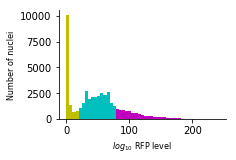

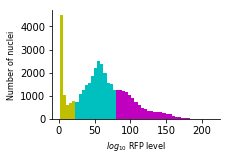

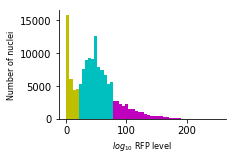

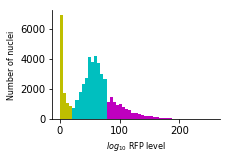

In [94]:
gd = {0:0, 1:1, 2:1, 3:2, 4:2}
_ = [scorer.build_classifier(gd) for scorer in scorers]

In [95]:
_ = [scorer.score() for scorer in scorers]

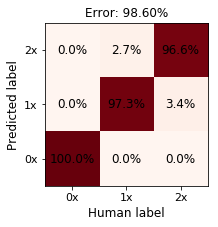

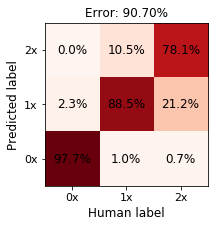

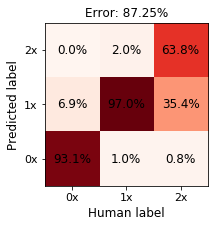

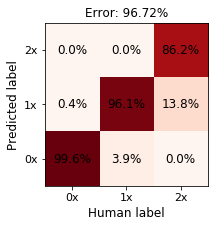

In [96]:
_ = [scorer.plot_score_matrix(predictor='genotype') for scorer in scorers]

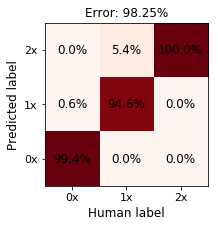

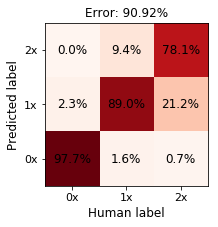

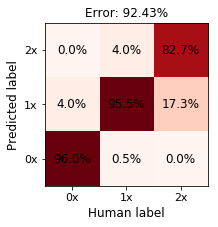

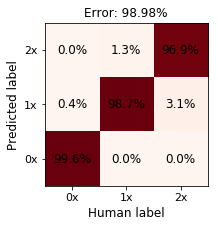

In [97]:
_ = [scorer.plot_score_matrix(predictor='km_label') for scorer in scorers]

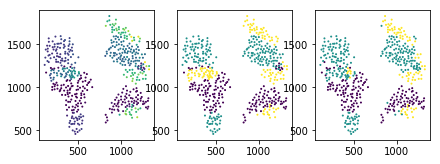

In [113]:
scorer = scorers[2]
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(7, 3))

s = 1
ax0.scatter(scorer.scores.centroid_x, scorer.scores.centroid_y, c=scorer.scores.r, s=s)
ax0.set_aspect(1)

ax1.scatter(scorer.scores.centroid_x, scorer.scores.centroid_y, c=scorer.scores.manual_genotype, s=s)
ax1.set_aspect(1)

ax2.scatter(scorer.scores.centroid_x, scorer.scores.centroid_y, c=scorer.scores.genotype, s=s)
ax2.set_aspect(1)

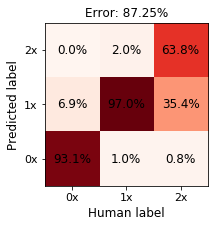

In [112]:
scorer.plot_score_matrix()

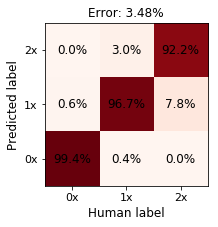

In [82]:
s = scorers[1]
s.plot_score_matrix()

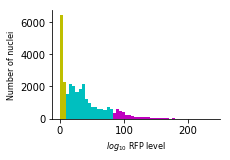

In [68]:
scorer = scorers[0]

gd = {0:0, 1:1, 2:1, 3:1, 4:1, 5:2, 6:2, 7:2}
scorer.build_classifier(gd) 

In [69]:
scorer.score()

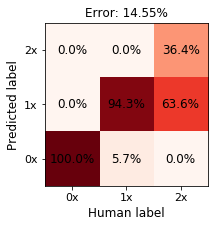

In [70]:
scorer.plot_score_matrix()

In [77]:
N_correct = (scorer.scores.km_label == scorer.scores.manual_genotype)
N_correct.sum()/len(scorer.scores)

0.9818181818181818

[None, None, None, None]

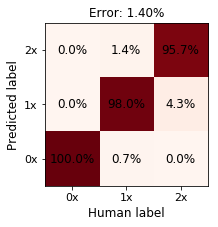

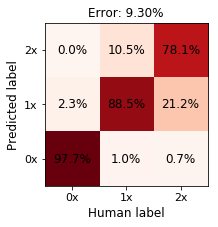

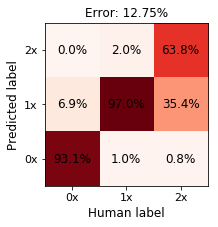

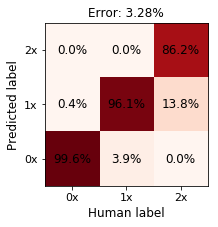

In [256]:
N = df.im_label.unique().size
cmap = ListedColormap(np.random.random((N, 3)), N=N)

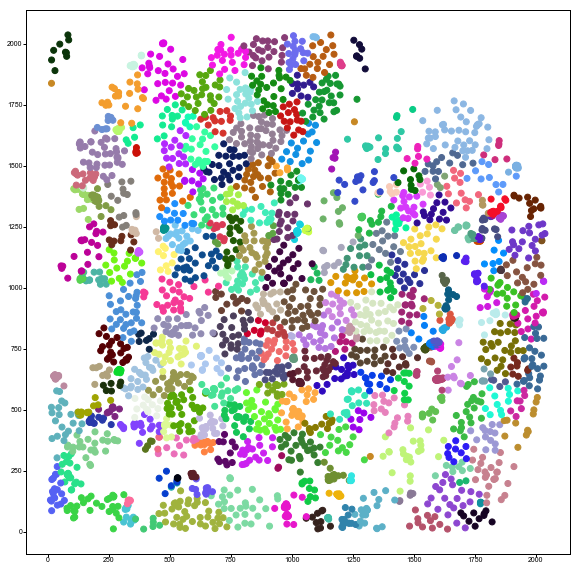

In [257]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df.centroid_x, df.centroid_y, c=df.im_label, cmap=cmap)
ax.set_aspect(1)

In [55]:
# Load paths to each set of experiments
control_path = '/Volumes/bernasek_t5/pnt_manuscript/microscopy/yan_clones/control/slices/w-eyFLP_PntGFP_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A'
mutant_path = '/Volumes/bernasek_t5/pnt_manuscript/microscopy/yan_clones/perturbation/slices/w-eyFLP_PntGFP_YanE833_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A'
control = Experiment(control_path)
mutant = Experiment(mutant_path)

# Define thresholds on a per-stack basis

In [6]:
stack = mutant[mutant.disc_names.index(42)]
df = get_stack_df(stack)

In [7]:
# create cell genotype classifier (operates on cells)
N = 3
gd = {0:0, 1:1, 2:2}
colors = ['y', 'c', 'm'][:3]
cmap = ListedColormap(colors, 'indexed', N=3)
classifier = CellClassifier.from_cells(df, classify_on='r', n=N, log=False, genotype_dict=gd, cmap=cmap)

fig, ax = plt.subplots(figsize=(3, 2))
_ = classifier.show(ax=ax)

#fig.savefig('../graphics/cell_classification.pdf', dpi=300, format='pdf', transparent=True, rasterized=True)

NameError: name 'CellClassifier' is not defined

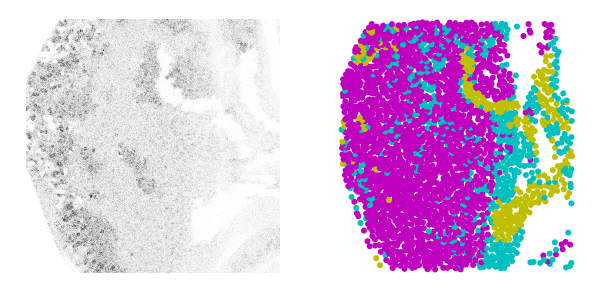

In [31]:
show_layer(stack[3], classifier)

In [391]:
for layer in stack:
    annotate_layer(layer, classifier, plot=True, dpi=100)

# Create cell genotype classifier

In [6]:
# compile all data for defining genotype thresholds
control_df = control.compile_measurements()
mutant_df = mutant.compile_measurements()
overall_df = pd.concat((control_df, mutant_df))
df = overall_df[overall_df.im_label!=-1]
df = df[df.near_furrow]

Text(0,0.5,'Number of nuclei')

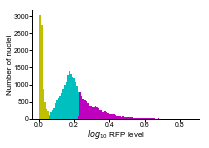

In [54]:
# create cell genotype classifier (operates on cells)
N = 9
genotype_dict = {0:0, 1:1, 2:1, 3: 1, 4: 2, 5:2, 6:2, 7:2, 8:2}
fig, ax = plt.subplots(figsize=(3, 2))
colors = ['y', 'c', 'm', 'k', 'r', 'g'][:3]
cmap = ListedColormap(colors, 'indexed', N=3)
cell_classifier = CellClassifier.from_cells(df, classify_on='r', n=N, log=False, genotype_dict=genotype_dict, cmap=cmap)
#cell_classifier = CellClassifier.from_im_clusters(df, classify_on='r_normalized', n=N, log=True, genotype_dict=genotype_dict, cmap=cmap)
_ = cell_classifier.show(ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('$log_{10}$ RFP level', fontsize=8)
ax.set_ylabel('Number of nuclei', fontsize=8)

In [88]:
# fig, ax = plt.subplots(figsize=(2, 1))
# bins = np.linspace(cell_classifier.x.min(), cell_classifier.x.max(), 100)
# _ = ax.hist(cell_classifier.x, bins=bins)

Text(0,0.5,'Number of nuclei')

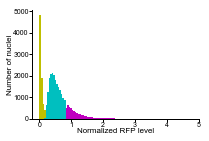

In [9]:
# fig, ax = plt.subplots(figsize=(3, 2))
# cell_classifier._show(10**cell_classifier.x, cell_classifier.labels, ax=ax)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.set_xlabel('Normalized RFP level', fontsize=8)
# ax.set_ylabel('Number of nuclei', fontsize=8)

In [404]:
import networkx as nx

In [406]:
nx.get_node_attributes(g, 10)

{}

# Check annotation

In [62]:
disc = mutant[9]
layer = disc[0]
disc.disc_name

'26'

(-83.70572048734462, 2129.6981708125445, 2133.7531919212565, -88.7816831174566)

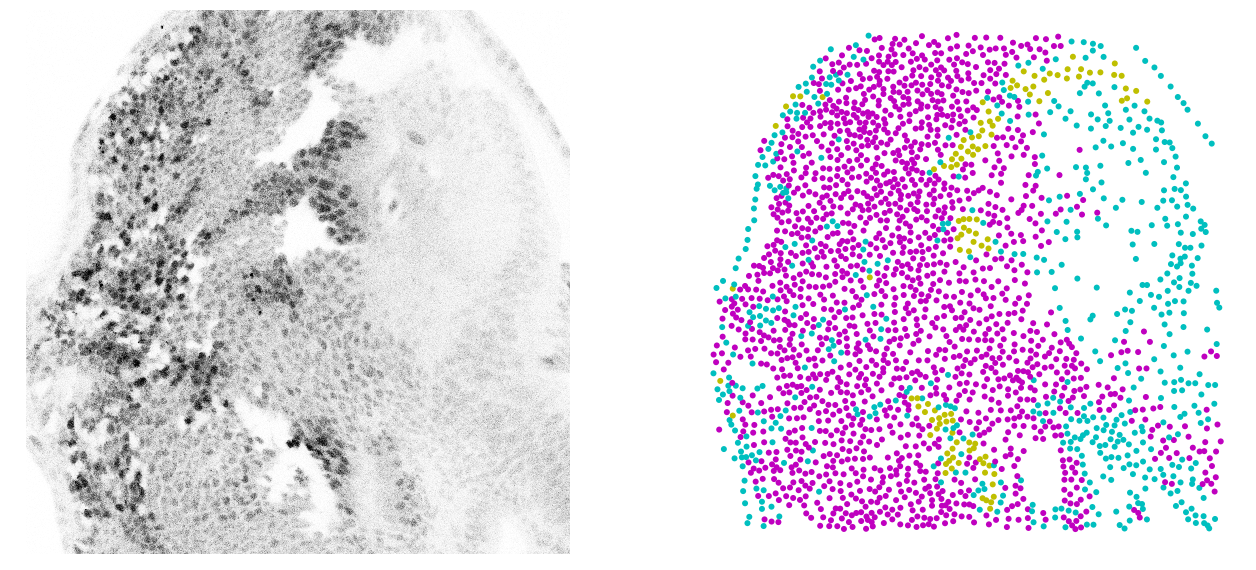

In [59]:
labels = cell_classifier(layer.df)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(22, 10))
xy = layer.df[['centroid_x', 'centroid_y']].values
_ = layer.get_channel('r').show(segments=False, ax=ax0, cmap=plt.cm.Greys)
ax1.scatter(*xy.T, c=labels, cmap=cell_classifier.cmap, lw=0)
ax1.invert_yaxis()
ax1.axis('off')

In [77]:
Counter(labels)

Counter({2: 1259, 1: 1076, 0: 140})

In [7]:
from modules.annotation import CloneMask
from collections import Counter
from modules.io import IO
import gc

def mark_clone_boundaries(layer):
    edges = layer.annotation.graph.edges
    assign_genotype = np.vectorize(dict(layer.df.genotype).get)
    edge_genotypes = assign_genotype(edges)
    boundaries = edge_genotypes[:, 0] != edge_genotypes[:, 1]
    boundary_nodes = np.unique(edges[boundaries])
    layer.df['boundary'] = False
    layer.df.loc[boundary_nodes, 'boundary'] = True

def annotate_layer(layer, cell_classifier, plot=True, dpi=100):
    
    # assign genotype to all cells in layer
    clone_classifier = CloneClassifier.from_layer(layer, cell_classifier)
    layer.df['genotype'] = clone_classifier.genotypes
    layer.df['km_label'] = cell_classifier(layer.df)
    mark_clone_boundaries(layer)
    
    # instantiate IO
    io = IO()
    
    # save updated contours
    contours = layer.df.to_json()
    
    if plot:
        
        # visualize clones for current layer
        fig, ax = plt.subplots(figsize=(10, 10))    
        layer.annotation.clone_mask = CloneMask.from_layer(layer)
        _ = layer.get_channel('r').show(segments=False, ax=ax, cmap=plt.cm.Greys)
        layer.annotation.plot_clones(ax=ax)

        # set image keyword arguments
        im_kw = dict(format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)

        # save figure
        fig.axes[0].axis('off') 

    
class CloneClassifier:
    def __init__(self, df, cell_classifier):
        self.im_to_genotype = self.build_classifier(df, cell_classifier)
        self.genotypes = self.__call__(df.im_label.values)
        
    def __call__(self, im_labels):
        return self.im_to_genotype(im_labels)
    
    @staticmethod
    def from_layer(layer, cell_classifier):
        return CloneClassifier(layer.df, cell_classifier)
    
    @classmethod
    def build_classifier(cls, df, cell_classifier):
        classify_im_cluster = lambda x: cls.get_mode(cell_classifier(x))
        im_to_genotype_dict = df.groupby('im_label').apply(classify_im_cluster).to_dict()
        im_to_genotype_dict[-1] = -1
        return np.vectorize(im_to_genotype_dict.get)        
        
    @staticmethod
    def get_mode(x):
        mode, count = Counter(x).most_common(1)[0]
        return mode

from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap, Normalize


class KM:
    
    def __init__(self, values, n=3, log=False, genotype_dict=None, cmap=None):
        self.n = n
        self.x = values
        self.log = log
        self.genotype_dict = genotype_dict
        if self.log:
            self.x = np.log10(self.x)
        
        self.kmeans(n)
        self.build_classifier(genotype_dict=genotype_dict)
        self.set_cmap(cmap)
        self.labels = self.classifier(self.x.reshape(-1, 1))
    
    def __call__(self, x):
        self.classifier(x)
        
    def set_cmap(self, cmap=None):
        if cmap is None:
            cmap = plt.cm.plasma
            norm = Normalize(vmin=0, vmax=self.n)
            colors = [cmap(norm(i)) for i in range(self.n)]
            self.cmap = ListedColormap(colors)
        else:
            self.cmap = cmap
        
    @staticmethod
    def _kmeans(x, n):
        return KMeans(n).fit(x.reshape(-1, 1))
    
    @staticmethod
    def _build_classifier(km):
        """ Create vectorized function for [x] values to genotypes. """
        centroids = km.cluster_centers_.ravel()
        flip = lambda f: f.__class__(map(reversed, f.items()))
        km_to_ordered_dict = flip(dict(enumerate(np.argsort(centroids))))
        km_to_ordered = np.vectorize(km_to_ordered_dict.get)
        classifier = lambda x: km_to_ordered(km.predict(x))
        return classifier
    
    def kmeans(self, n):
        self.n = n
        km = self._kmeans(self.x, n)
        self.km = km
    
    def build_classifier(self, genotype_dict=None):
        
        # map values to sequential clusters
        value_to_cluster = self._build_classifier(self.km)
        
        # map clusters to genotypes
        if genotype_dict is None:
            genotype_dict = {k: k for k in range(self.n)}
        cluster_to_genotype = np.vectorize(genotype_dict.get)
        
        # set classifier
        self.classifier = lambda x: cluster_to_genotype(value_to_cluster(x))
        
    def show(self, **kw):
        self._show(self.x, self.labels, **kw)
            
    def _show(self, x, genotypes, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        bins = np.linspace(x.min(), x.max(), 50)        
        for genotype in range(self.n):
            xi = x[(genotypes==genotype)]
            ax.hist(xi, bins=bins, facecolor=self.cmap(genotype))
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('$log_{10}$ RFP level', fontsize=8)
        ax.set_ylabel('Number of nuclei', fontsize=8)
        
    
class CellClassifier(KM):
    
    def __init__(self, values, classify_on='r_normalized', **kw):
        self.classify_on = classify_on
        KM.__init__(self, values, **kw)
    
    def __call__(self, df):
        x =  df[self.classify_on].values.reshape(-1, 1)
        if self.log:
            x = np.log10(x)
        return self.classifier(x)
        
    @staticmethod
    def from_cells(df, classify_on='r_normalized', **kw):
        values = df[classify_on].values
        return CellClassifier(values, classify_on, **kw)
    
    @staticmethod
    def from_im_clusters(df, by=None, classify_on='r_normalized', **kw):
        if by is None:
            by = ('disc_genotype', 'disc_id', 'layer', 'im_label')
        values = df.groupby(by=by)[classify_on].mean().values
        return CellClassifier(values, classify_on, **kw)

In [ ]:
w-eyFLP_PntGFP_YanE833_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A_Disc54b.silhouette

In [ ]:
for dirpath, dirnames, filenames in os.walk("."):
    for filename in [f for f in filenames if f.endswith(".log")]:
        print os.path.join(dirpath, filename)

In [119]:
p = '/Users/Sebi/Documents/grad_school/research/pnt_expression/flyeye_suite/discs/'

In [120]:
os.walk(p)

<generator object walk at 0x135fbaeb8>

In [140]:
searchstr = 'eyFLP_PntGFP_YanE833_FRT40A'

directories, files = [], []
for dirpath, dirnames, filenames in os.walk(p):
    directories.extend([d for d in dirnames if searchstr in d])
    files.extend([f for f in filenames if searchstr in f])

contains = lambda x: ('54' in x) and ('FRT40A' in x)

In [139]:
files

[]